> Extracting images from video
done


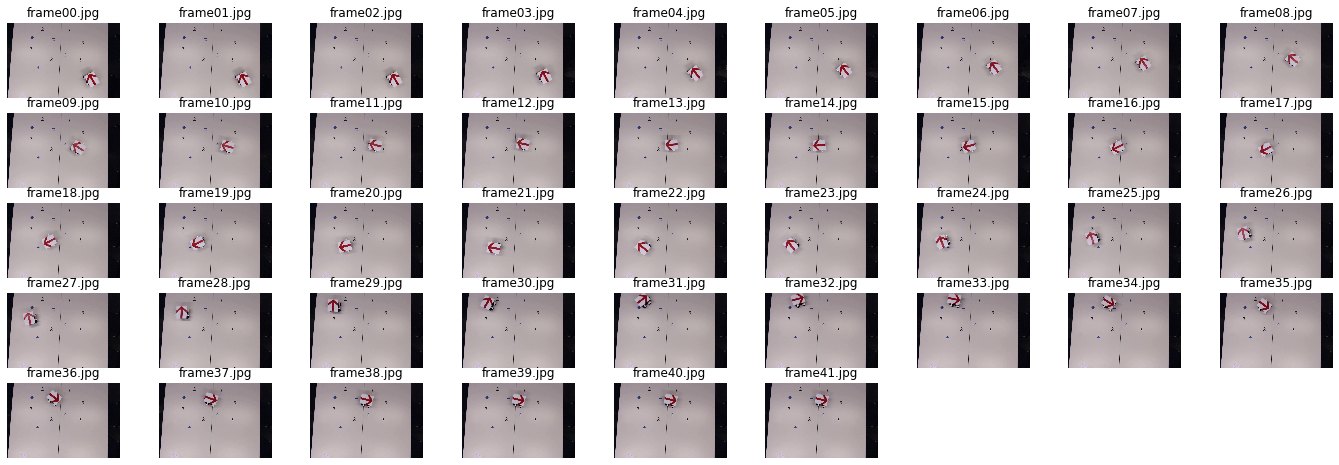

In [1]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data()

# plot images
fig, axes = plt.subplots(5, int(len(images)/5)+1, figsize=(24, 8))
for ax, im, nm in zip(axes.ravel(), images, images_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   
for ax in axes.ravel()[len(images):]:
    fig.delaxes(ax)

<b>###############################################################################################################################################################################################################</b> <br>
TEMPLATE MATCHING TEST

In [2]:
import skimage.io
robot_template = skimage.io.imread('./data/robot_template.jpg')

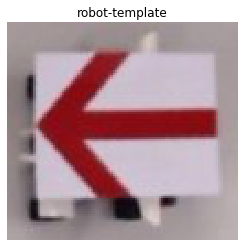

In [3]:
fig = plt.subplot(111)
plt.imshow(robot_template)
plt.axis('off')
plt.title('robot-template')   
plt.show()

105 3


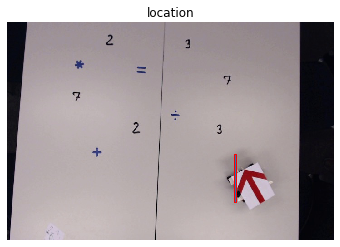

In [4]:
from skimage.feature import match_template

result = match_template(images[0], robot_template)
ij = np.unravel_index(np.argmax(result), result.shape)
_, x, y, = ij[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(images[0])
ax.axis('off')
ax.set_title('location')
# highlight matched region
_, hcoin, wcoin = robot_template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r')
ax.add_patch(rect)
plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
CHECK HISTOGRAM

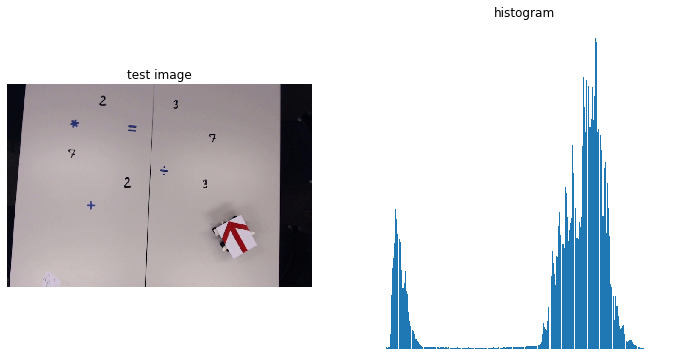

In [5]:
test_im = images[0]

fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes.ravel()
ax[0].imshow(test_im)
ax[0].axis('off')
ax[0].set_title('test image')
ax[1].hist(test_im.ravel(), bins=256)
ax[1].axis('off')
ax[1].set_title('histogram')
plt.show()

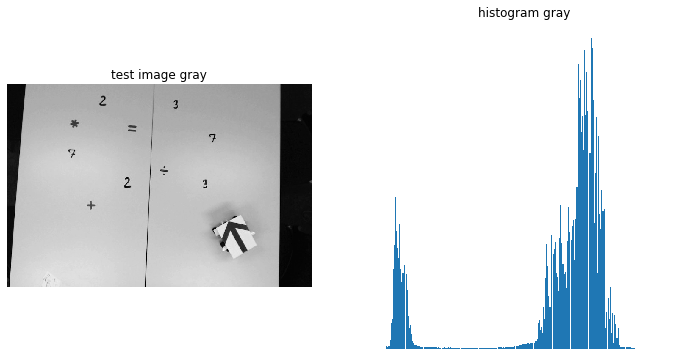

In [6]:
test_im_gray = skimage.color.rgb2gray(test_im)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes.ravel()

ax[0].imshow(test_im_gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('test image gray')
ax[1].hist(im.ravel(), bins=256)
ax[1].axis('off')
ax[1].set_title('histogram gray')
plt.show()

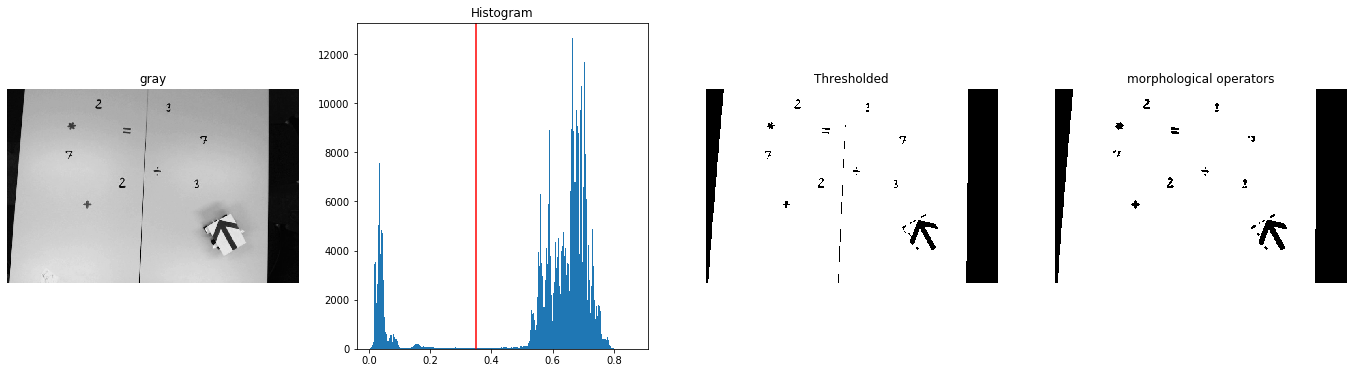

In [18]:
from skimage.filters import threshold_otsu
from skimage import morphology

thresh = threshold_otsu(test_im_gray)
binary = test_im_gray > thresh

fig, axes = plt.subplots(ncols=4, figsize=(24, 6))
ax = axes.ravel()

ax[0].imshow(test_im_gray, cmap='gray')
ax[0].set_title('gray')
ax[0].axis('off')

ax[1].hist(test_im_gray.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

close = morphology.binary_closing(binary, skimage.morphology.selem.disk(1))
erode = morphology.binary_erosion(close, skimage.morphology.selem.disk(1))

ax[3].imshow(erode, cmap=plt.cm.gray)
ax[3].set_title('morphological operators')
ax[3].axis('off')

plt.show()

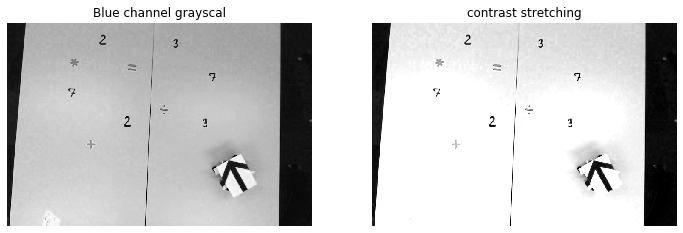

In [8]:
# Check exposure on whole image

from skimage import exposure

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
ax = axes.ravel()

#modify exposure of blue channel since the difference is more visible there
img = skimage.color.rgb2gray(test_im[:,:,2])

# Contrast stretching
a, b = np.percentile(img, (0.8, 50))
img_rescale = exposure.rescale_intensity(img, in_range=(a, b))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Blue channel grayscal')
ax[0].axis('off')
   
ax[1].imshow(img_rescale, cmap='gray')
ax[1].set_title('contrast stretching')
ax[1].axis('off')

plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
LABELING

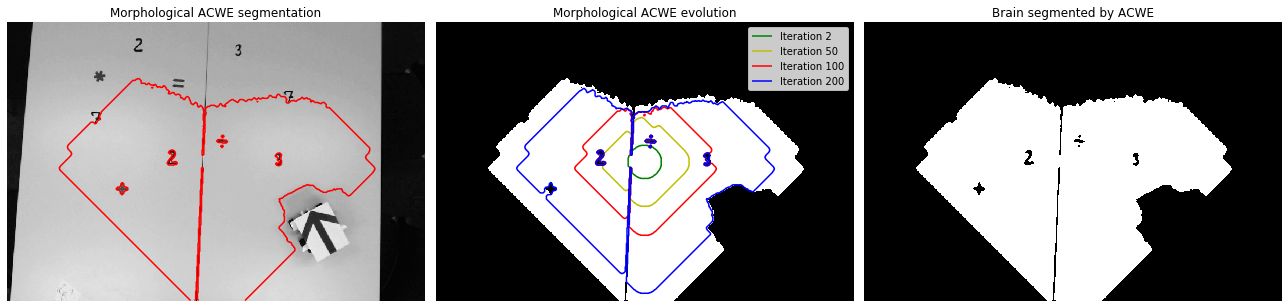

Size in pixels of the brain captured by the active contour method: 121489 pixels


In [23]:
# ACTIVE CONTOUR

from skimage import exposure
from skimage import feature
from skimage import filters
from skimage import morphology
from skimage import util
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_yen, threshold_minimum, threshold_otsu, threshold_multiotsu
from skimage.measure import label
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, square, star, rectangle, disk
from skimage.segmentation import flood, flood_fill, morphological_chan_vese, chan_vese, circle_level_set, checkerboard_level_set

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Initial level set
init_ls = circle_level_set(test_im_gray.shape, center = (test_im_gray.shape[0]/2, test_im_gray.shape[1]/2), radius = 27)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)

# Level sets active contour method 
ls = morphological_chan_vese(test_im_gray, 250, init_level_set=init_ls, smoothing=1, lambda1 = 190, lambda2 = 50,
                             iter_callback=callback)

# Display the result
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
ax = axes.ravel()

ax[0].imshow(test_im_gray, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[50], [0.5], colors='y')
contour.collections[0].set_label("Iteration 50")
contour = ax[1].contour(evolution[100], [0.5], colors='r')
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[200], [0.5], colors='b')
contour.collections[0].set_label("Iteration 200")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)

ax[2].imshow(ls, cmap='gray')
ax[2].set_title('Brain segmented by ACWE', fontsize = 12)
ax[2].axis('off')

fig.tight_layout()
plt.show()

# Count the number of pixels
pix_size = int(ls[ls==1].sum()/1)
print('Size in pixels of the brain captured by the active contour method: {} pixels'.format(pix_size))